# 疫情期间网民情绪识别   
数据简介: 数据集依据与“新冠肺炎”相关的230个主题关键词进行数据采集，   
抓取了2020年1月1日—2020年2月20日期间共计100万条微博数据，   
并对其中10万条数据进行人工标注，   
标注分为三类，分别为：1（积极），0（中性）和-1（消极）。

1. 数据探索 
2. 数据分析 
3. 数据集构造 
4. 解决方案

In [1]:
!ls raw_data/

nCoV_100k_train.labled.csv  nCoV_900k_train.unlabled.csv
nCov_10k_test.csv	    submit_example.csv


## 1. 数据集探索
1. 训练集 
2. 测试集 
3. 未标记语料 
4. 文本清理 

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### 1.1 训练集

In [3]:
# 读取训练数据集
raw_train_df = pd.read_csv('raw_data/nCoV_100k_train.labled.csv')
raw_train_df.head()

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频,情感倾向
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1
3,4456061509126470,01月01日 23:08,芩鎟,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,['https://ww2.sinaimg.cn/orj360/005FL9LZgy1gah...,[],1
4,4455979322528190,01月01日 17:42,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,[],[],1


In [4]:
# 选取文本相关的列与标签列
subset=['微博中文内容', '情感倾向']

train_df = raw_train_df[subset].dropna(subset=subset).drop_duplicates(['微博中文内容'])
train_df['文本长度'] = train_df['微博中文内容'].apply(lambda x: len(x))
train_df.head()

,微博中文内容,情感倾向,文本长度
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,147
1,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,47
2,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,1,99
3,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1,30
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1,145


In [5]:
# 对每列进行统计分析
for col in train_df.columns:
    print(train_df[col].describe())
    print('=' * 100)

count                                                 90113
unique                                                90113
top       我在看：【如果无疫苗出现，冠状病毒会持续吗？专家的回答告知答案】#跟新浪看热点#O如果无疫苗...
freq                                                      1
Name: 微博中文内容, dtype: object
count     90113
unique        8
top           0
freq      51328
Name: 情感倾向, dtype: object
count    90113.000000
mean        88.221466
std         49.179204
min          1.000000
25%         43.000000
50%         87.000000
75%        140.000000
max        241.000000
Name: 文本长度, dtype: float64


In [6]:
# 查看标签的唯一值有哪些
train_df['情感倾向'].unique()

array(['0', '-1', '1', '-', '4', '-2', '10', '9'], dtype=object)

In [7]:
# 查看文本长度等于1的文本内容
train_df[train_df['文本长度'] == 1]

,微博中文内容,情感倾向,文本长度
3846,唉,-1,1
6185,嗯,0,1
11822,马,0,1
13603,呵,0,1
19129,好,0,1
19152,！,0,1
20334,了,0,1
20868,哇,0,1
22644,？,0,1
24792,吨,0,1


In [8]:
# 选取正常标签的样本
train_df['good_sample'] = train_df['情感倾向'].apply(lambda x: x in ['-1', '0', '1'])
train_df[train_df['good_sample'].isin(['-1','0','1'])][subset].head()

,微博中文内容,情感倾向
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0
1,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1
2,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,1
3,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1


In [9]:
# 将中文列名转化为英文
train_df = train_df[train_df['good_sample']][subset]
train_df.rename(columns={'微博中文内容':'text', '情感倾向': 'label', '文本长度': 'text_length'}, inplace=True)
train_df.head()

,text,label
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0
1,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1
2,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,1
3,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1


### 1.2 测试集

In [10]:
raw_test_df = pd.read_csv('raw_data/nCov_10k_test.csv')
raw_test_df.head()

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频
0,4456068992182160,01月01日 23:38,-精緻的豬豬女戰士-,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概...,['https://ww2.sinaimg.cn/thumb150/745aa591ly1g...,[]
1,4456424178427250,01月02日 23:09,liujunyi88,大宝又感冒鼻塞咳嗽了，还有发烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情...,[],[]
2,4456797466940200,01月03日 23:53,ablsa,还要去输两天液，这天也太容易感冒发烧了，一定要多喝热水啊?,['https://ww3.sinaimg.cn/orj360/006fTidCly1gaj...,[]
3,4456791021108920,01月03日 23:27,喵吃鱼干Lynn,我太难了别人怎么发烧都没事就我一检查甲型流感?,[],[]
4,4457086404997440,01月04日 19:01,我的发小今年必脱单,果然是要病一场的喽回来第三天开始感冒今儿还发烧了喉咙眼睛都难受的一匹怎么样能不经意让我的毕设...,[],[]


In [11]:
test_df = raw_test_df[['微博中文内容']].dropna().drop_duplicates()
test_df.rename(columns={'微博中文内容':'text'}, inplace=True)
test_df.describe()

,text
count,9672
unique,9672
top,想说的很多，打了很多字都删掉了，最后千言万语汇成一句话，加油我的大中国，扛过这次恶魔的打击，...
freq,1


### 1.3 未标记语料

In [12]:
raw_unlabeled_df = pd.read_csv('raw_data/nCoV_900k_train.unlabled.csv')
raw_unlabeled_df.head()

,微博id,微博发布时间,发布人账号,微博中文内容,微博图片,微博视频
0,4456074364642450,01月01日 23:59,Dear_Christin,2020年第一天，宝宝晚上发烧了。上个月的肺炎经历还历历在目，不觉又开始揪心。目前低烧安稳睡...,[],[]
1,4456069114155340,01月01日 23:38,Maggie大美Y,生病发烧一直就没好～就当预示着2020年是个风风火火的好好好运年～新年第一天有肉吃，以后天天...,['https://ww1.sinaimg.cn/orj360/006TMJgaly1gah...,[]
2,4456068145061890,01月01日 23:34,折眉几年,害新年第一天就发烧????,[],[]
3,4456064403586410,01月01日 23:20,秃头少女Brushblog,是心动啊，糟糕眼神躲不掉。对你莫名的心跳，竟然停不了对你的迷恋感觉要发烧。@namjoohy...,['https://wx3.sinaimg.cn/orj480/63becc16gy1g7v...,['https://f.video.weibocdn.com/0009osQVlx07xJg...
4,4456060284446840,01月01日 23:03,Akemi庄蝶,过去的一整年有好好喜欢你。不过今年不可以啦，毕竟，可不能连自己都不要了。跨年给你打电话，听到...,[],[]


In [13]:
unlabeled_df = raw_unlabeled_df[['微博中文内容']].dropna().drop_duplicates()
unlabeled_df.rename(columns={'微博中文内容':'text'}, inplace=True)
unlabeled_df.describe()

,text
count,718286
unique,718286
top,数据呢//@小卓AI://@famfamfam://@白衣咸饭:这是信口开河，误国误民，增加...
freq,1


### 1.4 文本清理

In [14]:
# 随机抽取20条文本，查看文本内容
for text in train_df['text'].sample(20):
    print(text)
    print('=' * 100)

【直播！#上海135名医护人员驰援武汉#】今天，除夕夜，来自上海市第一人民医院、瑞金医院、华山医院、中山医院等医疗机构的135名医疗队成员集结出发，奔赴武汉支援抗击肺炎前线。看直播↓关注！致敬！（总台央视记者盛瑾瑜）央视新闻的微博直播.???
//@鸡茸菇超神之路:呵，这不就是媒体宣传“可防可控”“没有证据人传人”“武汉病例未增加”的那几天发生的事儿？
【男人肾虚6个信号】①脑力方面：记忆力下降；②情志方面：情绪不佳；③意志方面表现：缺乏自信；④性功能方面：性功能降低；⑤泌尿方面：尿频，尿等待，小便清长等症状。⑥其他：早衰健忘失眠，食欲不振，骨骼关节疼痛，腰膝酸软，不耐疲劳，乏力，视力减退，听力衰减。?
司莫司汀胶囊------山东济南百济抗肿瘤药大药房哪里能买到司莫司汀司莫司汀胶囊怎么保存司莫司汀吃几粒司莫司汀胶囊哪里有卖司莫司汀胶囊价格司莫司汀胶囊一线用于什么肿瘤司莫司汀胶囊是国产·的·司莫司汀胶囊怎么服用司莫司汀胶囊怎么样司莫司汀胶囊：北京天津石家庄太原呼和?展开全文c
钟南山院士关于“潜伏期24天”的解读O钟南山院士关于“潜伏期24天”的解读?
【周知：#什么是聚集性病例#】
使用钉钉建立疫情防控中心，联防联控、可以实时看到想了解的数据。你也不至于一问三不知！?
钟院士不但医术高明，英语也是超级棒
【家长注意护理小细节预防宝宝患上中耳炎】儿童中耳炎表现为耳深部搏动时跳痛或者刺痛，尤其是在吮吸、吞咽及咳嗽时，疼痛更会加剧，因此，患有中耳炎的宝宝会不爱吃奶。较小的宝宝表现为烦躁、摇头、揉耳以及哭闹，而会说话的宝宝则会表达自己的耳朵疼。?
武汉金银潭医院夏医生接受采访，说着说着就哭了，“我们已经做了一个医务工作者，所能做的一切……”心疼，致敬！#武汉市将对四类人员集中收治和隔离#L共青团福建省委的微博视频???
#宁夏治愈率41.5%#银川的管控真的特别严，之前去药店买东西忘记带小区门卡，出去了不到三分钟，保安蜀黍记得我都不让我进了，必须要有门卡才能进，最后是我妈出来把我带进去的还测了个体温?
抑郁症是不是舍曲林药物反应很重？我妈现在情绪平静了，但每天都觉得自己快死了，油尽灯枯。吃舍曲林第三天，感觉浑身乏力，一天比一天无力，肌肉僵硬，头部胀，犯困打哈欠，缺乏食欲，吃东西就恶心，一点荤的也吃不进。有没有一样的朋友呢？?
太对了！
//@二逼瓦西里://@1968金

### 文本特殊模式总结

1.回复、转发@的用户名：   //@快乐源泉李小半， //@李易峰:  
2.话题、标签： #抗击新型肺炎第一线#， #记录抗疫时光#  #摄影#          
3.表情：   
4.微博特有词：展开全文、网页链接、展开全文c  
5.网址： 

使用正则表达式进行模式匹配，清除无用的文本   
https://tool.oschina.net/uploads/apidocs/jquery/regexp.html

In [15]:
import re

# 1. 回复、转发@的用户名
pattern = '(//@)[^: ]+\:'
re.sub(pattern, ' ', '宁波//@京城吃货日记:这人我在罗马见过2-3次，罗马的厨师，宁波人，靠谱，单身。//@捞陈今天惨遭爆破了吗:看这个菜单就知道靠谱//@京城吃货日记:宁波的靠谱意大利餐外卖#最新疫情地图#')

'宁波 这人我在罗马见过2-3次，罗马的厨师，宁波人，靠谱，单身。 看这个菜单就知道靠谱 宁波的靠谱意大利餐外卖#最新疫情地图#'

In [16]:
# 4. 微博特有词：展开全文、网页链接、展开全文c
pattern = '[(转发微博)(\??展开全文c?)(网页链接\??)]'
re.sub(pattern, '', '转发微博 哈哈 网页链接? 每天有180-200万只?展开全文c')

' 哈哈  每天有180-200万只'

In [17]:
# 5. 网址
pattern = 'https?:\/\/\w+\.[a-z]{2,6}(\/[\da-zA-Z\_\-]*)*'
re.sub(pattern, '====', '快来加入陕西中医药大学超话和我一起聊聊吧~超话传送门→http://t.cn/RmUGDIM?')

'快来加入陕西中医药大学超话和我一起聊聊吧~超话传送门→====?'

In [18]:
def clean_text(text):
    pattern = 'https?:\/\/\w+\.[a-z]{2,6}(\/[\da-zA-Z\_\-]*)*'
    text = re.sub(pattern, ' ', text)
    pattern = '[(转发微博)(\??展开全文c?)(网页链接\??)]'
    text = re.sub(pattern, ' ', text)
    pattern = '(//@)[^: ]+\:'
    text = re.sub(pattern, ' ', text)
    pattern = '\s{2,}'  #合并连续的空格
    text = re.sub(pattern, ' ', text)
    text = text.strip().lower() # 去掉两边多余的空格，将大写转小写
    return text

In [19]:
text = '//@捞陈今天惨遭爆破了吗:看这个菜单就知道靠谱//@京城吃货日记:超话传送门→http://t.cn/RmUGDIM?哈哈哈?展开全文c'
clean_text(text)

'看这个菜单就知道靠谱 超话传送门→ 哈哈哈'

In [20]:
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))
train_df = train_df[train_df['text'] != '']
train_df.head()

,text,label
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0
1,年大模型…累到以为自己 烧了腰疼膝盖疼腿疼胳膊疼脖子疼#luna的krystallife#,-1
2,邱晨这就是我爹，爹， 烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,1
3,新年的第一天感冒又 烧的也太衰了但是我要想着明天一定会好的,1
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1


In [21]:
test_df['text'] = test_df['text'].apply(lambda x: clean_text(x))
test_df = test_df[test_df['text'] != '']
test_df.head()

,text
0,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻 烧（大概...
1,大宝又感冒鼻塞咳嗽了，还有 烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情...
2,还要去输两天液，这天也太容易感冒 烧了，一定要多喝热水啊
3,我太难了别人怎么 烧都没事就我一检查甲型流感
4,果然是要病一场的喽回来第三天 始感冒今儿还 烧了喉咙眼睛都难受的一匹怎么样能不经意让我的毕设...


In [22]:
unlabeled_df['text'] = unlabeled_df['text'].apply(lambda x: clean_text(x))
unlabeled_df = unlabeled_df[unlabeled_df['text'] != '']
unlabeled_df.head()

,text
0,2020年第一天，宝宝晚上 烧了。上个月的肺炎经历还历历在目，不觉又 始揪心。目前低烧安稳睡...
1,生病 烧一直就没好～就当预示着2020年是个风风火火的好好好运年～新年第一天有肉吃，以后天天有肉吃
2,害新年第一天就 烧
3,是心动啊，糟糕眼神躲不掉。对你莫名的心跳，竟然停不了对你的迷恋感觉要 烧。@namjoohy...
4,过去的一整年有好好喜欢你。不过今年不可以啦，毕竟，可不能连自己都不要了。跨年给你打电话，听到...


## 2. 数据分析  
1. 查看标签内容
2. 文本长度分布    
3. 文本标签分布 
4. 文本词云构造

### 2.1 查看标签内容

In [23]:
# 对每个标签随机抽取3条文本，查看文本内容
for label, group in train_df.groupby(by='label'):
    print(label)
    print()
    sentences = group.sample(3)['text'].tolist()
    print('\n\n'.join(sentences))
    print("=" * 30)

-1

河南好多农村真的没办法，不封老年人不重视，而且医疗条件差，平时 热都得跑镇里或者县严重的才去市里。。一个感染的来那基本是屠村了。。关于吃的北方的都知道过年囤的菜肉够吃半月的，加上米面馒头，今年走不来亲戚吃。。我家够我们吃一个月都不吃完

就希望火神山、雷神山医院尽快建成，没必要太精细，面面俱到，尽快投入使用吧，三座大山定能镇住恶役

#新闻联播#北京狡诈违占榜样刘月美揭露北京昌平区兴寿镇香屯村刘月美数年狡诈违占行为，其行为毁坏道路，扩大违占面积，阻碍村民出行！香屯村位于北京市昌平区小汤山九华山庄北侧，紧临北京草莓 览园既北京农业嘉年华举办地！刘月美宅基地位于香屯村西北角！其宅基地落成起至今一直在坚持一点点违
0

这应该是看到的第一篇对“诊断标准”制定标准过高的回应，但模糊了具体时间线，强调了认知水平的问题。——李兴旺、曹彬等国家卫健委第一批专家组与湖北省市卫健委一起制定了早期的诊断标准；诊断标准一共做了5次修改；这不是某一个专家的意见，而是大家的一个共识。

冬瓜蘑菇面①月龄：10月龄以上②食材：冬瓜：10克，蘑菇：15克，面条：适量③营养建议：在冬天选择食用冬瓜可健脾养颜，如宝宝在咳嗽有痰时，吃冬瓜是不错的选择，蘑菇中含有丰富的维生素d、优质蛋白质以及丰富的氨基酸，可提高人体免疫能力和抵抗能力。

太谷县公安局交警大队关于过境太谷城区车辆分流绕行的通告为有效贯彻落实省委、省政府重大突 公共卫生事件ι级响应措施及市委、巿政府相关部署要求，预防新型冠状病毒感染的肺炎疫情 生扩散，维护我县人民群众身体健康和生命安 ，保障途经我县城区的车辆顺利通行，决定对途经我县车辆进行分流绕
1

～祈福10斤～

今天你吃汤圆了吗祝愿大家元宵节快乐所有的医务人员辛苦了隔离的同胞们你们会快快好起来的2塔城地区·额敏县

【 改委：已能保障一线医护人员医用口罩防护需要】13日，国家 改委产业 司一级巡视员夏农在 布会上表示，口罩产量逐日提升。截至2月11日， 国口罩产能利用率已经达到94%，特别是一线防控急需的医用n95口罩，产能利用率达到128%。湖北的日产量从2月2日的4.5万只大幅度增长到2月11日的15.8万只。


### 2.2 文本长度分布

In [24]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [25]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x))
train_df.head()

,text,label,text_length
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,141
1,年大模型…累到以为自己 烧了腰疼膝盖疼腿疼胳膊疼脖子疼#luna的krystallife#,-1,45
2,邱晨这就是我爹，爹， 烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...,1,98
3,新年的第一天感冒又 烧的也太衰了但是我要想着明天一定会好的,1,29
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1,139


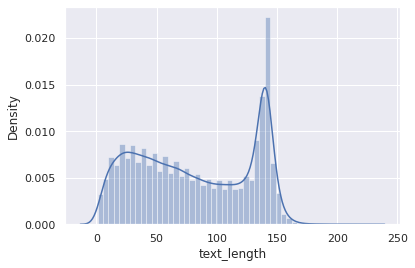

In [26]:
# 训练集文本长度分布

sns.set()
sns.distplot(train_df['text_length'])
plt.show()

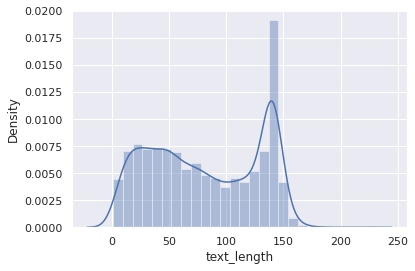

In [27]:
# 测试集文本分布

test_df['text_length'] = test_df['text'].apply(lambda x: len(x))
sns.set()
sns.distplot(test_df['text_length'])
plt.show()

#### 文本长度分布结果：
1. 文本长度在0-240之间  
2. 主要集中在150以内，在140左右分布最多 
3. 训练集与测试集保持相同的分布

### 2.3 文本标签分布

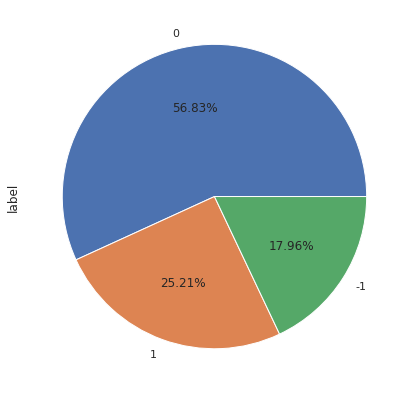

In [28]:
# 训练集文本各标签分布情况
plt.figure(figsize=[9,7])
train_df['label'].value_counts().plot.pie(autopct='%1.2f%%')
plt.show()

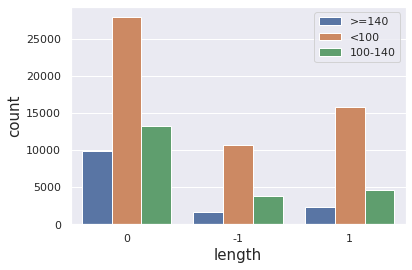

In [29]:
# 各标签文本长度分布情况，分为[0, 100], [100-140], [140-240]三档

def text_length_bucket(text_length):
    if text_length < 100:
        return '<100'
    elif 100 <= text_length < 140:
        return '100-140'
    else:
        return '>=140'

train_df['text_length_bucket'] = train_df['text_length'].apply(text_length_bucket)

sns.countplot('label',hue='text_length_bucket',data=train_df)

plt.xlabel('length',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.legend(loc='upper right')
plt.show()

#### 文本标签分布结果：
1. 各标签文本数量分布不均衡，分别为 [17.96, 56.83, 25.21]  
2. 各标签文本长度分布一致，大多数集中在<100以内

### 2.4 文本词云构造

“词云”就是通过形成“关键词云层”或“关键词渲染”，对网络文本中出现频率较高的“关键词”的视觉上的突出。词云图过滤掉大量的文本信息，使浏览网页者只要一眼扫过文本就可以领略文本的主旨。

In [30]:
import jieba

text = '写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。'
words = ' '.join(jieba.lcut(text))
words

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.711 seconds.
Prefix dict has been built successfully.


'写 在 年末 冬初 孩子 流感 的 第五天 ， 我们 仍然 没有 忘记 热情 拥抱 这 2020 年 的 第一天 。'

In [31]:
with open('./data/baidu_stopwords.txt', 'r') as f:
    stop_words = f.read().split('\n')

def cut_and_clean(text):
    cuted_text = ' '.join([x for x in jieba.lcut(text) if x not in stop_words and len(x) > 1])
    clean_text = re.sub('([\.，。、“”‘ ’？\?:#：【】\+!！])', ' ', cuted_text)
    clean_text = re.sub('\s{2,}', ' ', clean_text)
    return clean_text

cut_and_clean(text)

'年末 冬初 孩子 流感 第五天 忘记 热情 拥抱 2020 第一天'

In [32]:
train_text = ' '.join(train_df['text'].apply(cut_and_clean))
train_text[:1000]

'年末 冬初 孩子 流感 第五天 忘记 热情 拥抱 2020 第一天 一丝 迷信 早晨 孩子 红色 羽绒服 羽绒 祈祷 一年 孩子 身体 康健 一丝 焦虑 焦虑 孩子 过早 懂事 两岁 关注 情绪 深沉 地说 妈妈 终于 这句 刀子 扎入 模型 累到 腰疼 膝盖 腿疼 胳膊 脖子 luna krystallife 邱晨 我爹 烧快 毕竟 美好 假期 拿来 养病 不太好 假期 好好 享受 快乐 新年快乐 烧好 快快乐乐 度过 美好 假期 说不定 邱晨虫 泉州 泉州 理工学院 新年 第一天 感冒 太衰 我要 想着 明天 意念 想法 天神 记下来 想法 记下来 有坏 想法 天神 会记 头上 三尺 神灵 明白 地府 会记 厉害 意念 五分钟 当中 一分钟 两分钟 三分钟 当中 意念 长存 高烧 反反复复 眼睛 室友 带我去 烧中 建议 输液 拒绝 打针 东西 舒服 室友 不忍心 惨状 背过 身去 医生 好了吗 医生 好了吗 室友 明天 考试 跨坏 兰州 兰州 交通 大学 元旦 快乐 枇杷 手法 小结 故事 大人 故事 大人 枇杷 手法 静待 需求 大人 孩子 到来 几天 武汉 专业 手法 学员 阿敏 专程 告诉 喜欢 解决问题 感觉 用体 侧线 手法 好多 流感 娃调 枇杷 始记 真的 xkh 昨天 vv 舒服 描述 症状 感冒 没事 晚上 一回 老师 打算 医院 医院 我家 我争 坚定 到底 过意不去 值周 老师 小孩 厉害 医院 一量 38 7 新年 第一天 鼓掌 来看 线下 演出 热爱 克服困难 线上 演出 太炸 呼兰 赵晓卉 第一次 近距离 明星 哈哈哈哈 一年 希望 更要 勇敢 更要 坚强 思想 内心 想法 一个 在外 一点 一个 过生日 没什么 尴尬 惊喜 来自 东哥 2020 第一天 真的 2020 第一天 姨妈 难受 新年 心愿 魔幻 2020 第一天 感冒 梦乡 一日游 上海 新年 第一天 感冒 希望 一年 顺顺利利 在家 上学 打个 喷嚏 癌症 晚期 北京 时间 11 38 一个 晚上 难受 弄个 毛巾 第一次 厉害 快死了 祭奠 我行 朋友 灭绝 眼睛 晚安 分享 单曲 kshapeofmyheart 电影 杀手 太冷 片尾曲 易云 音乐 2020 第一天 红红火火 芒市 新年 第一天 当中 2020 第一天 冷暖自知 年少 相识 成长 互相照顾 经历

In [33]:
import wordcloud
WC = wordcloud.WordCloud(font_path='./data/MSYH.TTC', 
                         max_words=1000,
                         height= 600,
                         width=1200,
                         background_color='white',
                         repeat=False,
                         mode='RGBA')

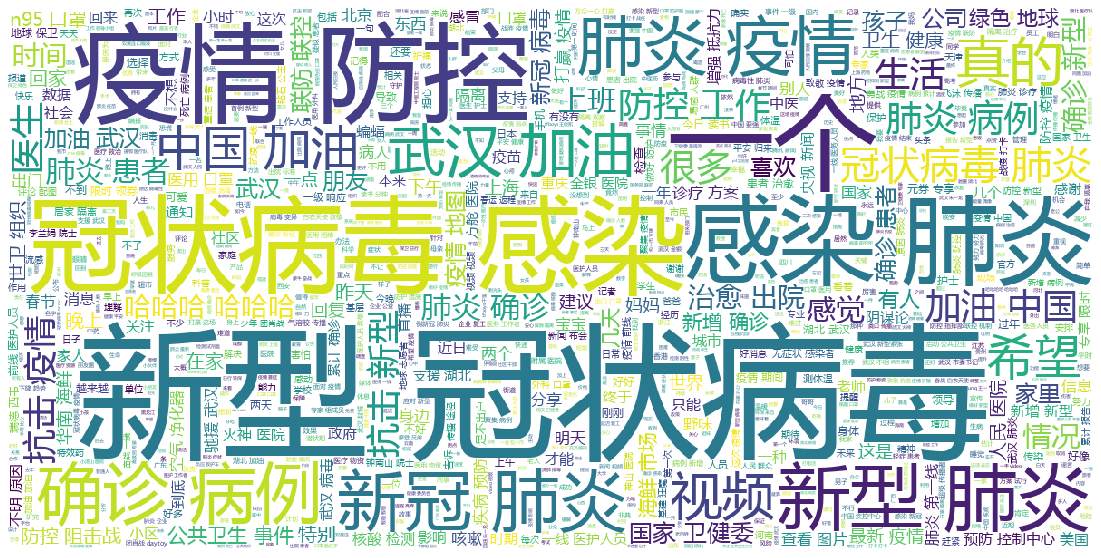

In [34]:
word_cloud_img = WC.generate(train_text)
plt.figure(figsize = (20,10))
plt.imshow(word_cloud_img, interpolation='nearest')
plt.axis("off")
WC.to_file('./data/wordcloud.png')

## 3. 数据集构造 
1. 划分训练与验证集
2. 合并无标签的数据

In [35]:
print(f"trian data count: {len(train_df)}")
print(f"test data count: {len(test_df)}")
print(f"unlabeled data count: {len(unlabeled_df)}")

trian data count: 89816
test data count: 9631
unlabeled data count: 716399


### 3.1 划分训练与验证集
### 90000 -> 80000训练 + 10000验证

In [36]:
from sklearn.model_selection import train_test_split

# 将标签[-1, 0, 1] 转化为 [0, 1, 2]
train_df['label'] = train_df['label'].apply(lambda x: int(x)+1).astype(int)

# 将有标签的训练数据集划分为训练、测试
train, test = train_test_split(train_df, test_size=10000, random_state=100)

len(train), len(test)

(79816, 10000)

In [37]:
train[['text', 'label']].to_csv('./processed_data/train.csv', index=False, encoding='utf-8')
test[['text', 'label']].to_csv('./processed_data/test.csv', index=False, encoding='utf-8')

### 3.2 合并无标签的数据
训练 + 测试 + 未标记

In [38]:
# 将所有的数据集合并在一起，构造相应的语料集

unlabeled = pd.concat([train_df[['text']], test_df[['text']], unlabeled_df])
unlabeled.head()

,text
0,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...
1,年大模型…累到以为自己 烧了腰疼膝盖疼腿疼胳膊疼脖子疼#luna的krystallife#
2,邱晨这就是我爹，爹， 烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新...
3,新年的第一天感冒又 烧的也太衰了但是我要想着明天一定会好的
4,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...


In [39]:
unlabeled.count()

text    815846
dtype: int64

In [40]:
unlabeled.to_csv('./processed_data/unlabeled.csv', index=False, encoding='utf-8')

## 4. 解决方案思考
### 240字以内、样本不均衡、“新冠肺炎”相关的文本3分类问题
### 
在机器学习中，样本不均衡是非常常见的现象。目前来看处理样本不均衡主要有一下三类方法：

1. 增加所需要的样本 
2. 过采样或者负采样，构造平衡的样本分布 
3. 训练中对每个类别添加不同的权重, 损失函数加权 

#### 接下来的实战中会介绍在Xgboost和Tensorflow中是如何处理样本不均衡的问题。